# This is a data pipeline for churn prediction of the youtube data set


In [1]:
# Here we are importing neccesary libraries
# Getting the libraries
import csv
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# First we get the data
data = pd.read_csv('Claned data.csv')

# We can see the data
print(data.head())
# We can see the data types
print(data.dtypes)


   ID  Video Duration Video Publish Time  Days Since Publish  Day  Month  \
0   0             201         2016-06-02                   0    2      6   
1   1             391         2016-06-10                   8   10      6   
2   2             133         2016-06-14                   4   14      6   
3   3              14         2016-06-29                  15   29      6   
4   4              45         2016-07-01                   2    1      7   

   Year Day of Week  Revenue per 1000 Views (USD)  \
0  2016    Thursday                         0.024   
1  2016      Friday                         0.056   
2  2016     Tuesday                         0.014   
3  2016   Wednesday                         0.004   
4  2016      Friday                         0.000   

   Monetized Playbacks (Estimate)  ...  Watched (Not Skipped) (%)  \
0                           723.0  ...                        0.0   
1                           727.0  ...                        0.0   
2                

In [3]:
# Next i want to convert into a dataframe
df = pd.DataFrame(data)

#Next we want to prepare the data for the pipeline, ill start by dropping the columns that are not needed, that being the ID  column
df = df.drop(columns=['ID'])

# Since we do not have a churn column, we will have to create one from the subscriber and unsubscriber columns
df['Net_Subscriber_Change'] = df['New Subscribers'] - df['Unsubscribes']

# Define a threshold for churn (e.g., 0 means any negative net change is churn)
threshold = 0
df['Churn_Label'] = df['Net_Subscriber_Change'].apply(lambda x: 1 if x < threshold else 0)

## Here we start messing around with feature engineering

In [4]:
# Here we are performing feature engineering
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer



# 1️⃣ Temporal Features
df['Video Publish Time'] = pd.to_datetime(df['Video Publish Time'], errors='coerce')
df['Publish_Weekday'] = df['Video Publish Time'].dt.dayofweek  # 0 = Monday
df['Publish_Month'] = df['Video Publish Time'].dt.month
df['Publish_Season'] = df['Publish_Month'].apply(lambda x: 
    'Winter' if x in [12, 1, 2] else 
    'Spring' if x in [3, 4, 5] else 
    'Summer' if x in [6, 7, 8] else 
    'Fall')

# Sine-Cosine encoding for cyclic features
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

# 2️⃣ Engagement Metrics
df['Like_Rate'] = df['Likes'] / (df['Views'] + 1e-5)
df['Comment_Rate'] = df['New Comments'] / (df['Views'] + 1e-5)
df['Share_Rate'] = df['Shares'] / (df['Views'] + 1e-5)
df['Sub_Conversion_Rate'] = df['New Subscribers'] / (df['Views'] + 1e-5)
df['Unsub_Rate'] = df['Unsubscribes'] / (df['Views'] + 1e-5)

# 3️⃣ Monetization Features
df['CPM_Drift'] = df['Playback-Based CPM (USD)'] - df['CPM (USD)']
df['Revenue_Efficiency'] = df['Estimated Revenue (USD)'] / (df['Views'] + 1e-5)
df['Ad_Density'] = df['Ad Impressions'] / (df['Views'] + 1e-5)
df['Premium_Watch_Share'] = df['YouTube Premium Watch Time (hours)'] / (df['Watch Time (hours)'] + 1e-5)

# 4️⃣ Retention & Duration Metrics
df['Engagement_Depth'] = df['Average View Duration'] / (df['Video Duration'] + 1e-5)
df['Retention_Rate'] = df['Average View Percentage (%)'] / 100

# 5️⃣ Categorical Encodings (basic prep)
categorical_cols = ['Day of Week', 'Publish_Season']
numeric_cols = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and col not in ['ID']]

# Example ColumnTransformer setup
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])


In [5]:
# Here we are preparing the data for the model
sample_df = df.copy().dropna()  # or df.sample(n=100) for random testing
engineered_cols = [
    'Like_Rate', 'Comment_Rate', 'Share_Rate', 'Sub_Conversion_Rate', 'Unsub_Rate',
    'CPM_Drift', 'Revenue_Efficiency', 'Ad_Density', 'Premium_Watch_Share',
    'Engagement_Depth', 'Retention_Rate'
]

# Inspect results
print(sample_df[engineered_cols].describe())

        Like_Rate  Comment_Rate  Share_Rate  Sub_Conversion_Rate  Unsub_Rate  \
count  364.000000    364.000000  364.000000           364.000000  364.000000   
mean     0.048933      0.003687    0.001811             0.002537    0.000261   
std      0.019585      0.003257    0.001226             0.002176    0.000684   
min      0.018844      0.000000    0.000225             0.000000    0.000000   
25%      0.034535      0.001954    0.001056             0.001332    0.000070   
50%      0.042884      0.002915    0.001548             0.002044    0.000187   
75%      0.061708      0.004211    0.002254             0.002938    0.000310   
max      0.119023      0.029034    0.011608             0.018369    0.012229   

        CPM_Drift  Revenue_Efficiency  Ad_Density  Premium_Watch_Share  \
count  364.000000          364.000000  364.000000           364.000000   
mean     0.494728            0.000112    0.164814             0.011966   
std      0.571609            0.000178    0.191653        

In [6]:
# Here i want to prepocess the pipeline
from sklearn.pipeline import Pipeline

# Combine numeric and categorical columns (already set earlier)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform
X_processed = pipeline.fit_transform(sample_df)

print("Shape after preprocessing:", X_processed.shape)

Shape after preprocessing: (364, 72)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import pandas as pd


# 🧱 Step 1: Reapply Feature Engineering
df['Video Publish Time'] = pd.to_datetime(df['Video Publish Time'], errors='coerce')
df['Publish_Weekday'] = df['Video Publish Time'].dt.dayofweek
df['Publish_Month'] = df['Video Publish Time'].dt.month
df['Publish_Season'] = df['Publish_Month'].apply(lambda x:
    'Winter' if x in [12, 1, 2] else
    'Spring' if x in [3, 4, 5] else
    'Summer' if x in [6, 7, 8] else
    'Fall'
)

df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

# Engagement metrics
df['Like_Rate'] = df['Likes'] / (df['Views'] + 1e-5)
df['Comment_Rate'] = df['New Comments'] / (df['Views'] + 1e-5)
df['Share_Rate'] = df['Shares'] / (df['Views'] + 1e-5)
df['Sub_Conversion_Rate'] = df['New Subscribers'] / (df['Views'] + 1e-5)
df['Unsub_Rate'] = df['Unsubscribes'] / (df['Views'] + 1e-5)

# Monetization metrics
df['CPM_Drift'] = df['Playback-Based CPM (USD)'] - df['CPM (USD)']
df['Revenue_Efficiency'] = df['Estimated Revenue (USD)'] / (df['Views'] + 1e-5)
df['Ad_Density'] = df['Ad Impressions'] / (df['Views'] + 1e-5)
df['Premium_Watch_Share'] = df['YouTube Premium Watch Time (hours)'] / (df['Watch Time (hours)'] + 1e-5)

# Retention & watch metrics
df['Engagement_Depth'] = df['Average View Duration'] / (df['Video Duration'] + 1e-5)
df['Retention_Rate'] = df['Average View Percentage (%)'] / 100

# 🧼 Step 2: Define columns for preprocessing
categorical_cols = ['Day of Week', 'Publish_Season']
numeric_cols = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and col not in ['ID']]

# ColumnTransformer setup
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

# Pipeline execution
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_processed = pipeline.fit_transform(df)

# 🧪 Inspect results
print("✅ Feature matrix shape:", X_processed.shape)

✅ Feature matrix shape: (364, 72)


## Next we are going to work on feature importance before we beging to train the model


In [8]:
# Here we will do some modelling, we shall use XGBoost 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Assume churn label is in df['Churn_Label']
y = df['Churn_Label']
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)



C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:42:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
df['Dropoff_Index'] = df['Average View Percentage (%)'] / df['Engagement_Depth']
df['SubLoss_Weight'] = df['Unsub_Rate'] * df['Ad_Density']

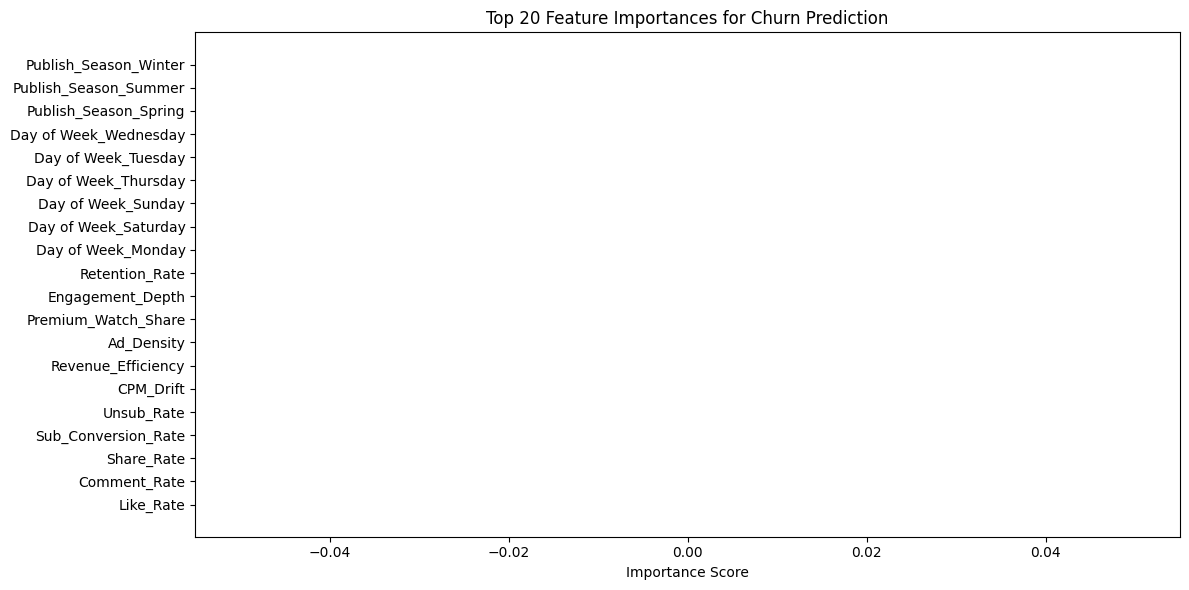

In [ ]:
# Here we will plot feature importance
import matplotlib.pyplot as plt

# Get original column names from preprocessing
feature_names_num = numeric_cols
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Plot importance
importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(12,6))
plt.barh(all_feature_names[sorted_idx][:20], importances[sorted_idx][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances for Churn Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Rerun the code chunk to see the bars

## Here we are refining the pipeline

In [11]:
# Here we are refining the pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define refined column lists
refined_numeric = [
    'Retention_Rate', 'Engagement_Depth', 'Premium_Watch_Share',
    'Ad_Density', 'Revenue_Efficiency', 'CPM_Drift', 'Unsub_Rate',
    'Sub_Conversion_Rate', 'Share_Rate', 'Comment_Rate', 'Like_Rate'
]

refined_categoricals = ['Day of Week', 'Publish_Season']

# Build ColumnTransformer
refined_preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), refined_numeric),
    ('cat', OneHotEncoder(drop='first'), refined_categoricals)
])

# Wrap in pipeline
refined_pipeline = Pipeline(steps=[
    ('preprocessor', refined_preprocessor),
    # You can plug in a classifier here next
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

## Here we are creating the final pipeline with the updated features

In [12]:
#Here we are creating a dynamic churn label based on rolling thresholds
unsub_thresh = df['Unsubscribes'].rolling(window=7).median().bfill()
ret_thresh = df['Retention_Rate'].rolling(window=7).mean().bfill()
rev_thresh = df['Estimated Revenue (USD)'].rolling(window=7).median().bfill()
# Here we define a function to dynamically label churn based on thresholds
# This function checks if the number of unsubscribes exceeds a rolling threshold
def dynamic_churn(row):
    return int(
        (row['Unsubscribes'] > unsub_thresh[row.name]) and (
            row['Retention_Rate'] < ret_thresh[row.name] or
            row['Estimated Revenue (USD)'] < rev_thresh[row.name]
        )
    )

df['Churn_Label'] = df.apply(dynamic_churn, axis=1)

In [13]:
# Here we are checking the value counts of the churn label
y = df['Churn_Label']
print(y.value_counts())  # Confirm it's ~259:105

Churn_Label
0    259
1    105
Name: count, dtype: int64


In [14]:
import numpy as np
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# ✅ Adaptive churn label already built
y = df['Churn_Label']

# ⚖️ Calculate scale_pos_weight for class imbalance
scale = len(y[y == 0]) / len(y[y == 1])

# 🔧 Define refined classifier with imbalance sensitivity
xgb_model = XGBClassifier(
    scale_pos_weight=scale,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

# 🧪 Final pipeline (preprocessing + SMOTE + model)
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', refined_preprocessor),        # Feature transformation
    ('smote', SMOTE(random_state=42, k_neighbors=1)),  # Class balancing (set to 1 for small folds)
    ('classifier', xgb_model)                      # Model
])

# 📉 Cross-validation setup
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
f1_scores, precision_scores, recall_scores = [], [], []

for train_idx, test_idx in cv.split(df, y):
    y_train_fold = y.iloc[train_idx]
    # Check if both classes are present and at least 2 samples in the minority class
    class_counts = y_train_fold.value_counts()
    if len(class_counts) < 2 or class_counts.min() < 2:
        continue
    X_train_fold = df.iloc[train_idx]
    X_test_fold = df.iloc[test_idx]
    y_test_fold = y.iloc[test_idx]

    final_pipeline.fit(X_train_fold, y_train_fold)
    y_pred = final_pipeline.predict(X_test_fold)

    f1_scores.append(f1_score(y_test_fold, y_pred, zero_division=0))
    precision_scores.append(precision_score(y_test_fold, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test_fold, y_pred, zero_division=0))

# 🧾 Display averaged results
print("Cross-validated scores (adaptive label, balanced class weights):")
print(f"✅ F1 Score:      {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"✅ Precision:     {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"✅ Recall:        {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f'✅ Confusion Matrix:\n{confusion_matrix(y_test_fold, y_pred)}')

Cross-validated scores (adaptive label, balanced class weights):
✅ F1 Score:      0.5530 ± 0.0710
✅ Precision:     0.4953 ± 0.0713
✅ Recall:        0.6349 ± 0.1038
✅ Confusion Matrix:
[[38 13]
 [11 10]]


The accuracy is rather poor here but it can be improved.

## Here are visualizing the info to better understand

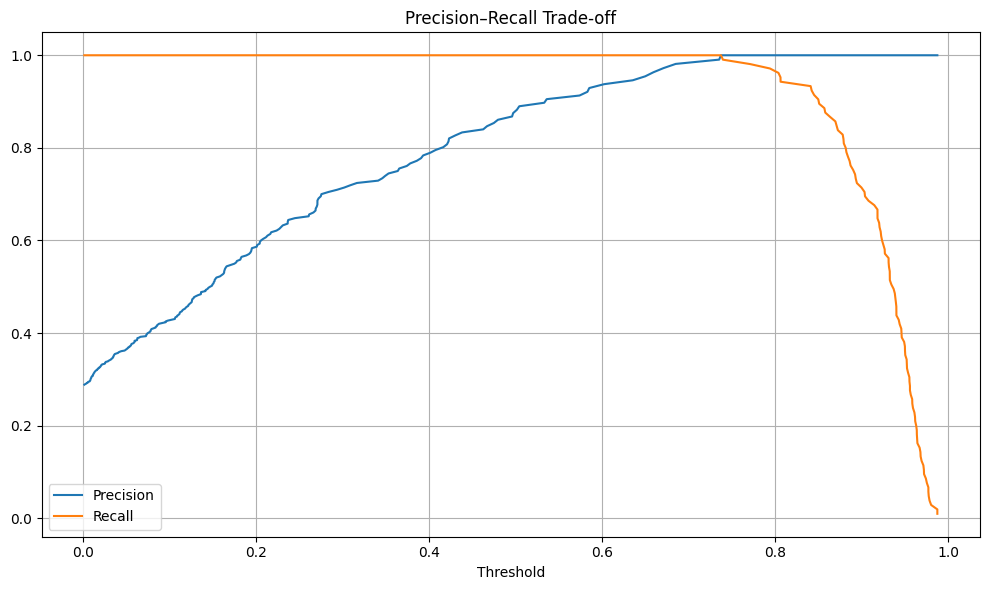

In [15]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for entire dataset
final_pipeline.fit(df, y)
probs = final_pipeline.predict_proba(df)[:, 1]

# Generate precision-recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y, probs)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_vals[:-1], label='Precision')
plt.plot(thresholds, recall_vals[:-1], label='Recall')
plt.xlabel("Threshold")
plt.title("Precision–Recall Trade-off")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

the graph above is going to used to choose the probs value

In [16]:
# Here we are setting a custom threshold for predictions
custom_preds = (probs >= 0.735).astype(int)
# Here we are checking the classification report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(classification_report(y, custom_preds, target_names=["No Churn", "Churn"]))
print(confusion_matrix(y, custom_preds))
# here we are calculating the F1 score for the custom threshold
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-6)
best_index = np.argmax(f1_scores)
best_thresh = thresholds[best_index]

print(f"🔍 Best threshold by F1 Score: {best_thresh:.2f}")

              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00       259
       Churn       0.99      1.00      1.00       105

    accuracy                           1.00       364
   macro avg       1.00      1.00      1.00       364
weighted avg       1.00      1.00      1.00       364

[[258   1]
 [  0 105]]
🔍 Best threshold by F1 Score: 0.74


The accuracy is utterly fantastic and thats great

## Here i want to see which features impact churning

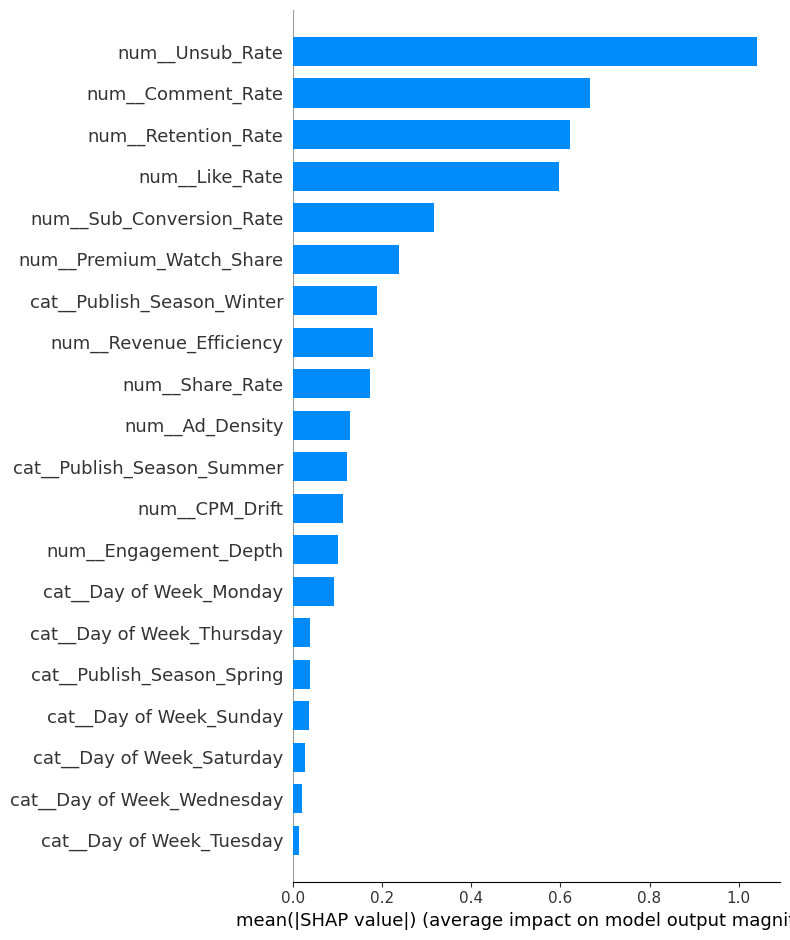

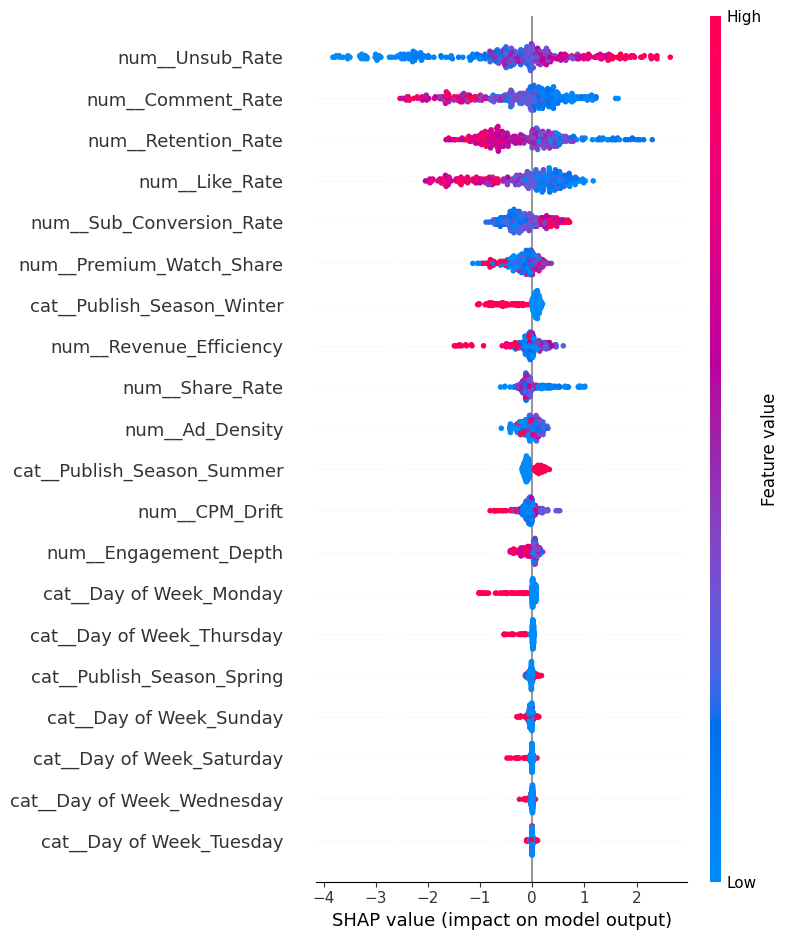

In [17]:
# First we have to extract the trained model
# Since we are using SHAP we need import a java library
import shap
shap.initjs()

# Fit the model
final_pipeline.fit(df, y)

# Get churn probability estimates
df['Predicted_Prob'] = final_pipeline.predict_proba(df)[:, 1]  # Prob of class 1 (churn)
df['Predicted_Label'] = final_pipeline.predict(df)
# Here we are extracting the trained model and transforming the data

final_pipeline.fit(df, y)
model = final_pipeline.named_steps['classifier']
X_transformed = final_pipeline.named_steps['preprocessor'].transform(df)


# Here we want to create a SHAP explainer
import shap

# Get the feature names from the preprocessor before using them
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)
# Next i want to plot feature impact using a bar chart which will use the feature names from the preprocessor
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, plot_type='bar')

shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

# Here we shall inspect individual predictions
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=refined_preprocessor.get_feature_names_out())


# Here the pipeline is being adjusted to deal with viewer engagment metrics

C:\Users\Admin\AppData\Local\Temp\ipykernel_214496\2768890112.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


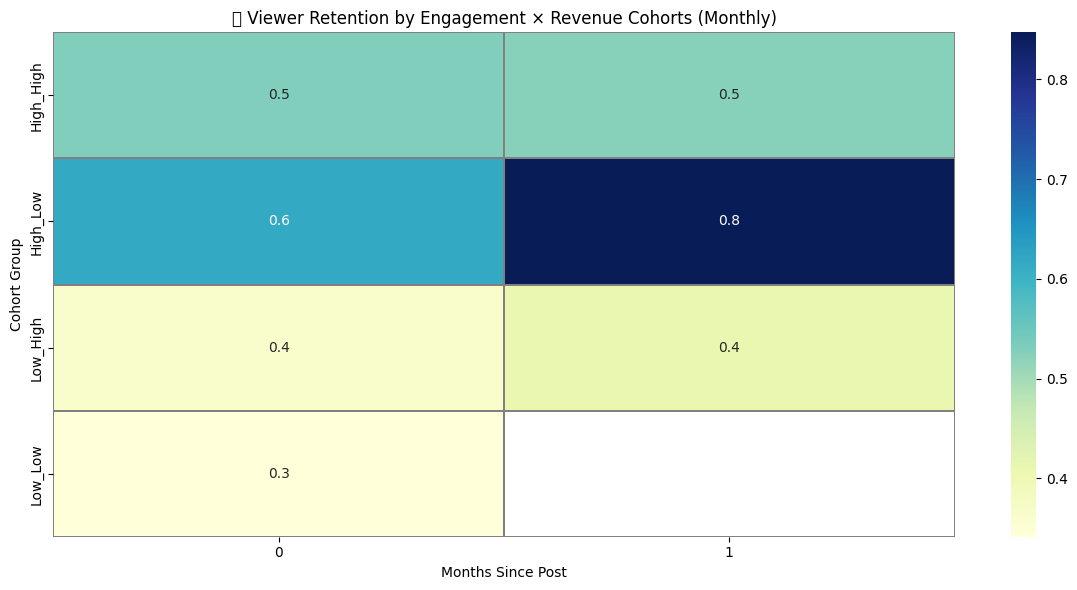

C:\Users\Admin\AppData\Local\Temp\ipykernel_214496\2768890112.py:40: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


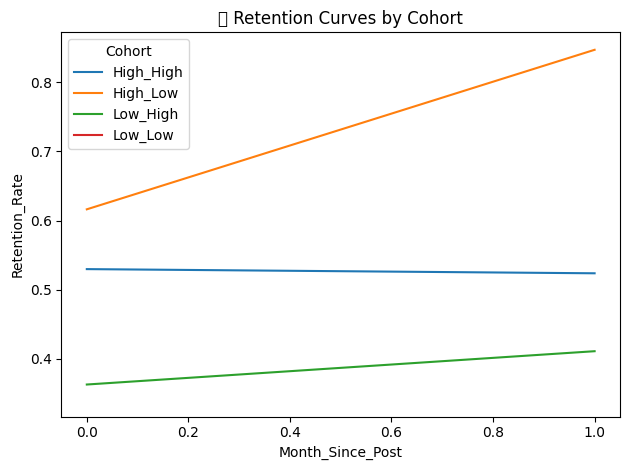

In [18]:

# Define tiers
df['Engagement_Tier'] = pd.qcut(df['Engagement_Depth'], q=3, labels=["Low", "Medium", "High"])
df['Revenue_Tier'] = pd.qcut(df['Estimated Revenue (USD)'], q=3, labels=["Low", "Medium", "High"])
df['Cohort'] = df['Engagement_Tier'].astype(str) + "_" + df['Revenue_Tier'].astype(str)

# Focus on high-signal cohorts only
top_cohorts = ["High_High", "High_Low", "Low_High", "Low_Low"]
df_filtered = df[df['Cohort'].isin(top_cohorts)].copy()

# Create Weeks_Since_Post from Days Since Publish
df_filtered['Weeks_Since_Post'] = (df_filtered['Days Since Publish'] // 7).astype(int)

# Aggregate over time (group weeks into months)
df_filtered['Month_Since_Post'] = df_filtered['Weeks_Since_Post'] // 4

# Build retention matrix
retention_matrix = df_filtered.groupby(['Cohort', 'Month_Since_Post'])['Retention_Rate'].mean().unstack()

# Plot clean heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    retention_matrix,
    cmap="YlGnBu",
    annot=True,
    fmt=".1f",
    linewidths=0.3,
    linecolor='gray'
)
plt.title("📊 Viewer Retention by Engagement × Revenue Cohorts (Monthly)")
plt.ylabel("Cohort Group")
plt.xlabel("Months Since Post")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Here i want to add in a temporal line plot to visualize churn trends over time
df_grouped = df_filtered.groupby(['Month_Since_Post', 'Cohort'])['Retention_Rate'].mean().reset_index()
sns.lineplot(data=df_grouped, x='Month_Since_Post', y='Retention_Rate', hue='Cohort')
plt.title("📈 Retention Curves by Cohort")
plt.tight_layout()
plt.show()

## Laslty we need to save the pipeline

In [19]:
# Here we are saving the pipeline using joblib
import joblib

# Save pipeline
joblib.dump(final_pipeline, 'adaptive_churn_pipeline.joblib')

['adaptive_churn_pipeline.joblib']

# KPI creation and formation on loyalty retention

In [20]:
# Replace zero denominators to avoid division errors
df['Unsub_Rate'] = df['Unsub_Rate'].replace(0, 0.0001)
df['CPM_Drift'] = df['CPM_Drift'].replace(0, 0.0001)

# Compute the index
df['Engagement_Stability_Index'] = (
    df['Engagement_Depth'] * df['Retention_Rate']
) / (df['Unsub_Rate'] + df['CPM_Drift'])

# Next we shall categorize the data
def categorize_esi(val):
    if val < 0.5:
        return "Low"
    elif val < 1.5:
        return "Medium"
    else:
        return "High"

df['ESI_Tier'] = df['Engagement_Stability_Index'].apply(categorize_esi)



# Next we are going to export it to Powerbi for intergration
df.to_csv("viewer_insights_with_ESI.csv", index=False)


In [21]:
# Use feature names from the preprocessor
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
shap_df = pd.DataFrame(shap_values, columns=feature_names)
# If you want to add columns from the original df, you can do so by index
shap_df['Season'] = df['Publish_Season']
shap_df['ID'] = df.index

# Next we are going to export it to Powerbi for intergration
df.to_csv("SHAP.csv", index=False)